In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly
import matplotlib.cm as cm
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples
from google_drive_downloader import GoogleDriveDownloader as gdd
import warnings 
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
gdd.download_file_from_google_drive(file_id='1S5stL1xz51y5QkGRHHfWqteacHDYOYXM', dest_path= '/quake.csv')

In [ ]:
df = pd.read_csv('/quake.csv')

In [ ]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


In [ ]:
df.dtypes

Focal depth      int64
Latitude       float64
Longitude      float64
Richter        float64
dtype: object

Focal Depth


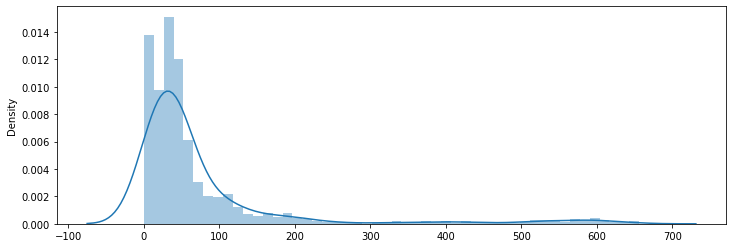

Latitude


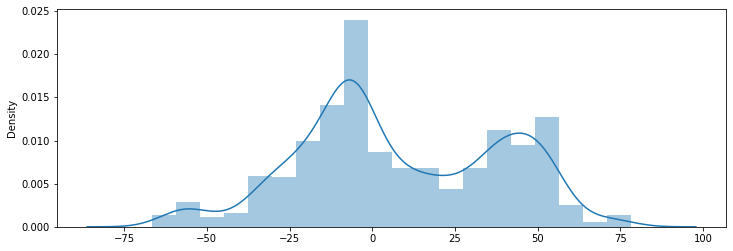

Longitude


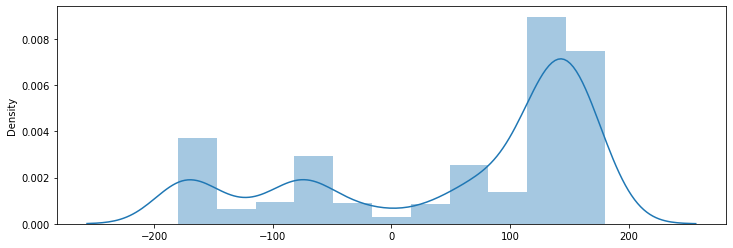

Richter


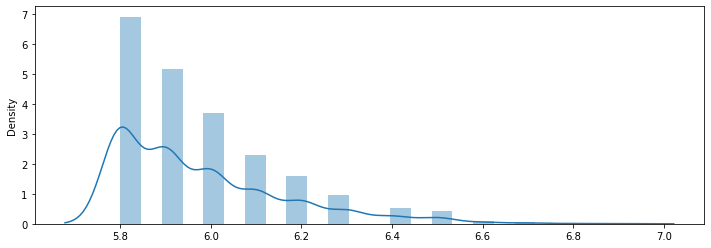

In [ ]:
for col in df.columns:
  plt.figure(figsize = (12, 4))
  print(col.title())
  sns.distplot(x = df[col])
  plt.show()

In [ ]:
#No missing values at all
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Richter,0,0.0
Longitude,0,0.0
Latitude,0,0.0
Focal depth,0,0.0


In [ ]:
for col in df.columns:
  print(col.title(), df[col].nunique())

Focal Depth 312
Latitude 1824
Longitude 1958
Richter 12


In [ ]:
df['Richter'].value_counts()

5.8    691
5.9    518
6.0    370
6.1    228
6.2    158
6.3     95
6.4     53
6.5     44
6.6     11
6.7      6
6.9      2
6.8      2
Name: Richter, dtype: int64

In [ ]:
#Lat long coordinates have a problem that they are 2 features that represent a three-dimensional space. 
#This means that the long coordinate goes all around, which means the two most extreme values are actually very close together. 
coord_x = np.cos(df['Latitude']) * np.cos(df['Longitude'])
coord_y = np.cos(df['Latitude']) * np.sin(df['Longitude'])
coord_z = np.sin(df['Latitude'])

In [ ]:
df_coord = df.copy()
df_coord['coord_x'] = pd.Series(coord_x)
df_coord['coord_y'] = pd.Series(coord_y)
df_coord['coord_z'] = pd.Series(coord_z)

In [ ]:
df_coord.drop(columns = ['Latitude', 'Longitude'], inplace = True)

In [ ]:
#Fuction for visualization
def vziz(data, labels, model):
  u_labels = np.unique(labels)
  plt.figure(figsize = (15, 6))
  for i in u_labels:
    plt.scatter(data[label == i, 0], data[label == i, 1], label = i)
  #centroids = model.cluster_centers_
  #plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
  plt.legend()
  plt.show()

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 10))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=20, rotation=70)
    plt.show()

In [ ]:
X= np.asarray(df_coord)

In [ ]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(2178, 5)

In [ ]:
pca = PCA(2)
data_pca = pca.fit_transform(X) 
data_pca.shape

(2178, 2)

In [ ]:
#KMEANS with 15 clusters
KMeans_15 = KMeans(n_clusters = 15)
label = KMeans_15.fit_predict(data_pca)
print(label)

[14 11 13 ...  5  2  6]


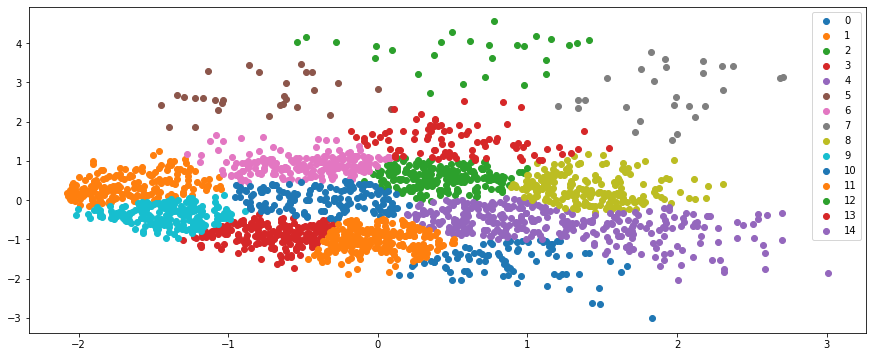

In [ ]:
#Plotting KMeans with 15 clusters
vziz(data_pca, label, KMeans_15)

In [ ]:
#Let's figure out what is the number of clusters of kmeans using elbow method
n_clusters = 30
cost = []
for i in range(1, n_clusters):
  kmean = KMeans(i)
  kmean.fit(data_pca)
  cost.append(kmean.inertia_)

Text(0, 0.5, 'Inertia')

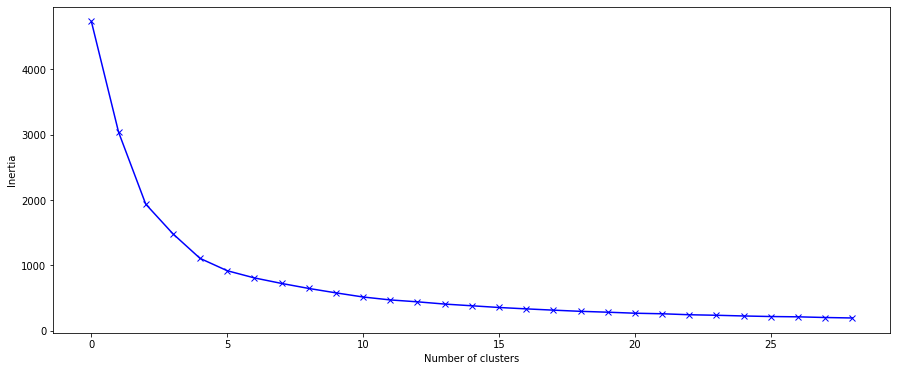

In [ ]:
#Looks like 4 clusters is the optimal variant
plt.figure(figsize=(15,6))
plt.plot(cost, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")

In [ ]:
#Plotting KMeans with 4 clusters
KMeans_3 = KMeans(n_clusters = 4)
label_3 = KMeans_3.fit_predict(data_pca)

In [ ]:
kmeans_labels_mapping = dict(zip([0, 1, 2], ['label_0', 'label_1', 'label_2', 'label_3']))

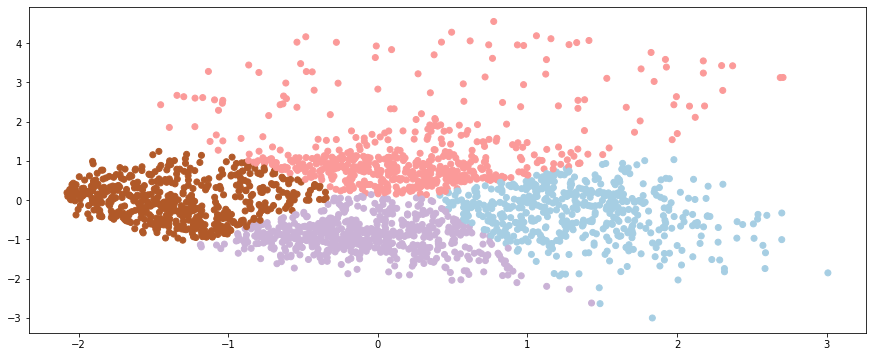

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(data_pca[:,0], data_pca[:,1],c=label_3, cmap='Paired')

   DBSCAN Time

In [ ]:
#I'd use the number of features times two as the vale for min samples
min_samples = df.shape[1]*2
dbscan = DBSCAN(eps = 0.5, min_samples = min_samples)
clusters = dbscan.fit_predict(X)
print('Clusters created: ' + str(list(set(clusters))))
#We have got the data point didn't make it into a cluster and remained unclustered

Clusters created: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, -1]


In [ ]:
#Implement DBSCAN with Elbow method 
k = min_samples if min_samples > 2 else 2 
nbrs = NearestNeighbors(n_neighbors = k).fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
#You can see the shape of the distances returned (2178, 8)
#This is because there are 2178 rows in our dataset
#And for each row I asked knearest to return the distance of the 8 closest points
#The first element in each row of the distance is equal 0, because it is the distance from itself
print('min samples: '+ str(min_samples))
print('shape of distances matrix: '+ str(distances.shape) + '\n')
for enum, row in enumerate(distances[:5]):
  print('observations '+ str(enum) + ': ' + str([round(x, 2) for x in row]))

min samples: 8
shape of distances matrix: (2178, 8)

observations 0: [0.0, 1.15, 1.31, 1.35, 1.35, 1.39, 1.42, 1.46]
observations 1: [0.0, 0.02, 0.05, 0.06, 0.08, 0.1, 0.11, 0.18]
observations 2: [0.0, 0.1, 0.29, 0.5, 0.5, 0.52, 0.52, 0.53]
observations 3: [0.0, 0.3, 0.49, 0.58, 0.59, 0.62, 0.64, 0.69]
observations 4: [0.0, 0.29, 0.3, 0.3, 0.32, 0.35, 0.37, 0.44]


In [ ]:
#The last column represents the distance of the k'th farthest point 
data_x = pd.DataFrame(X)
data_x['kfarthest'] = distances[:,-1]
data_x.head()

,0,1,2,3,4,kfarthest
0,-0.355201,3.816707,0.877564,0.117746,-1.343146,1.459524
1,-0.329437,-0.935570,0.117812,0.102632,1.387803,0.176607
2,-0.149088,-0.935570,0.241601,1.158575,-1.250116,0.528205
3,-0.063208,1.176553,1.236433,-0.174359,-1.173690,0.689327
4,-0.380965,0.120492,-1.753248,-0.215679,-0.505220,0.438183


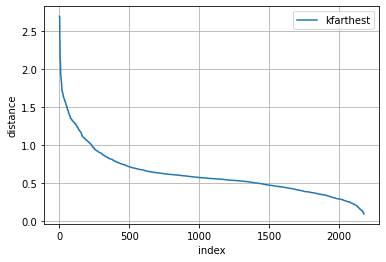

In [ ]:
#According to plot the optimal value of epsilon should be around 1
data_x.sort_values('kfarthest', ascending = False).reset_index()[['kfarthest']].plot()
plt.xlabel('index')
plt.ylabel('distance')
plt.grid(True)
plt.show()

In [ ]:
dbscan = DBSCAN(eps = 1, min_samples = min_samples)
clusters = dbscan.fit_predict(X)
print('Clusters created: ' + str(list(set(clusters))))

Clusters created: [0, 1, 2, 3, -1]


In [ ]:
dbscan_labels_mapping = dict(zip([-1, 0, 1, 2], ['OUTLIER', 'label_0', 'label_1', 'label_2', 'label_3']))

In [ ]:
#To my mind DBSCAN performed not so well
fig = px.scatter(data_pca, x=data_pca[:,0], y=data_pca[:,1], color = clusters)
fig.update_layout(title='Hierarchical Clustering')
fig.show()

   Hierarchical Clustering

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=4)

In [ ]:
y_agglomerative = agglomerative.fit_predict(data_pca)

In [ ]:
fig = px.scatter(x_pca, x=x_pca[:,0], y=x_pca[:,1], color = y_agglomerative)
fig.update_layout(title='Hierarchical Clustering')
fig.show()

In [ ]:
agglomerative_labels_mapping = dict(zip([0, 1, 2], ['label_0', 'label_1', 'label_2', 'label_3']))

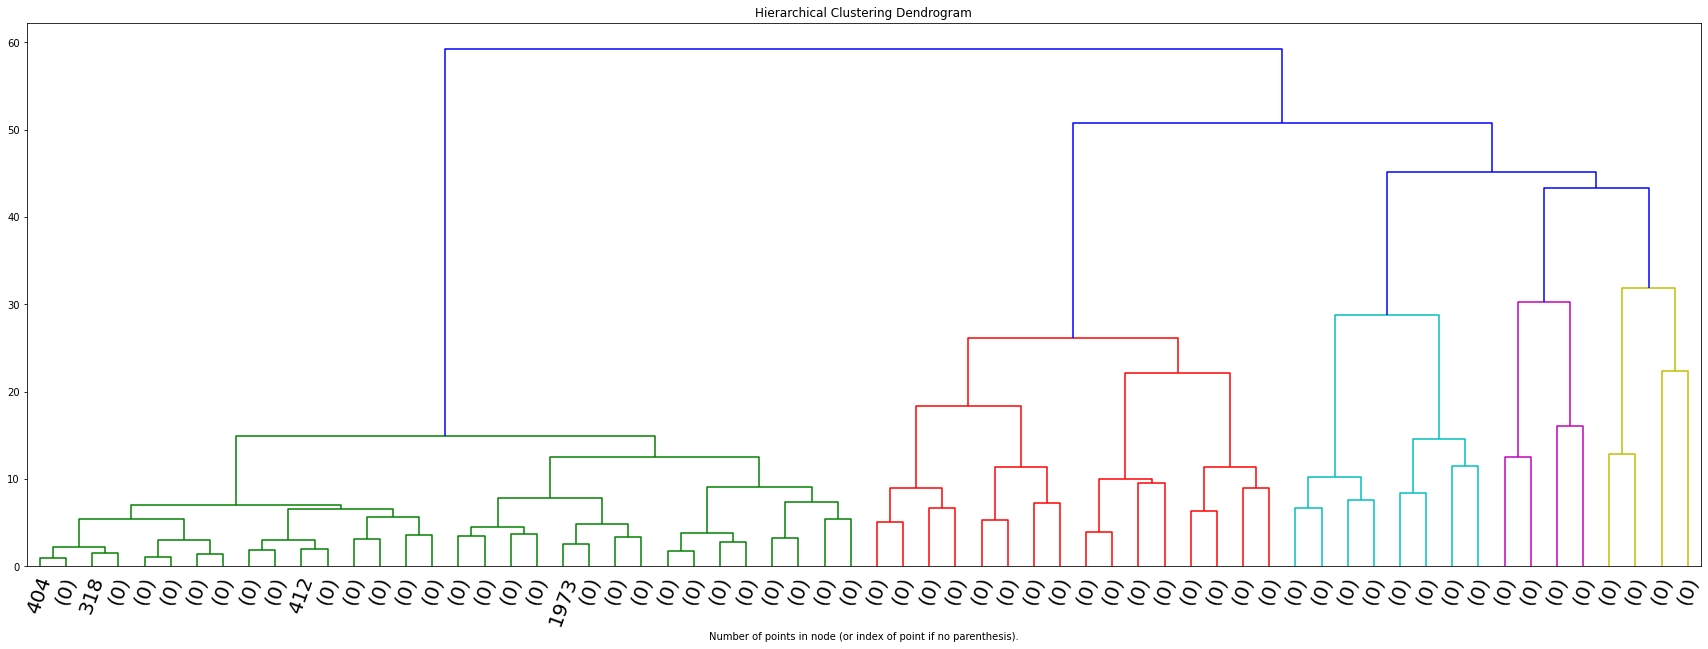

In [ ]:
model_hierar = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model_hierar = model_hierar.fit(X)

plot_dendrogram(model_hierar, truncate_mode='level', p=5) # p=3,5,7

   Metrics

In [ ]:
label_cols = ['kmeans_label', 'DBSCAN_label', 'agglomerative_label']

In [ ]:
data_x['agglomerative_label'] = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)
data_x['kmeans_label'] = pd.Series(label_3).map(kmeans_labels_mapping)
data_x['DBSCAN_label'] = pd.Series(clusters).map(dbscan_labels_mapping)

In [ ]:
data_x.isna().sum()

0                        0
1                        0
2                        0
3                        0
4                        0
kfarthest                0
agglomerative_label    386
kmeans_label           551
DBSCAN_label             8
dtype: int64

In [ ]:
#The dataframe contains NaNs in label_cols. Think we should input with most occurring class.
#I don't think this is actually correct, because metrics will estimate half of filled values and not predicted 
data_x['DBSCAN_label'].replace({np.NaN: 'OUTLIER'}, inplace=True)

In [ ]:
data_x = data_x.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [ ]:
for col in label_cols:
    print(f'Adjusted MI score for {col} = {adjusted_mutual_info_score(data_x["kmeans_label"], data_x[col])}')

Adjusted MI score for kmeans_label = 1.0
Adjusted MI score for DBSCAN_label = 0.02721104138637346
Adjusted MI score for agglomerative_label = 0.5570209763842886


In [ ]:
for col in label_cols:
    print(f'Adjusted rand score for {col} = {adjusted_rand_score(data_x["kmeans_label"], data_x[col])}')

Adjusted rand score for kmeans_label = 1.0
Adjusted rand score for DBSCAN_label = -0.030413483603436427
Adjusted rand score for agglomerative_label = 0.40793040493918714


In [ ]:
for col in label_cols:
    print(f'Calinski Harabasz score for {col} = {calinski_harabasz_score(X, data_x[col])}')

Calinski Harabasz score for kmeans_label = 305.07197834625475
Calinski Harabasz score for DBSCAN_label = 128.3557009432691
Calinski Harabasz score for agglomerative_label = 334.54646901348


In [ ]:
def plot_silhoette(model, X, X_2d, max_num_clusters=5):
    for n_clusters in range(2, max_num_clusters):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_2d[:, 0], X_2d[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.19594228967394436
For n_clusters = 3 The average silhouette_score is : 0.22282420274447706
For n_clusters = 4 The average silhouette_score is : 0.22841196682522028
For n_clusters = 5 The average silhouette_score is : 0.23732643253487035


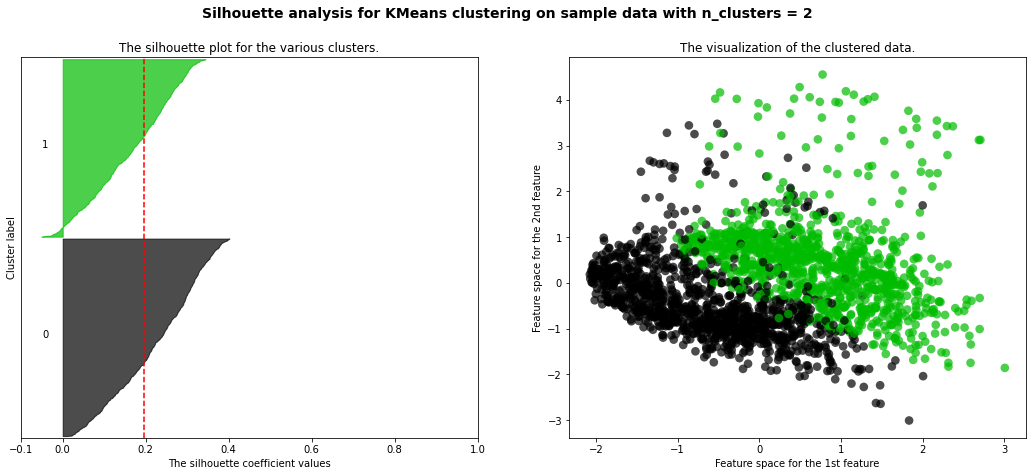

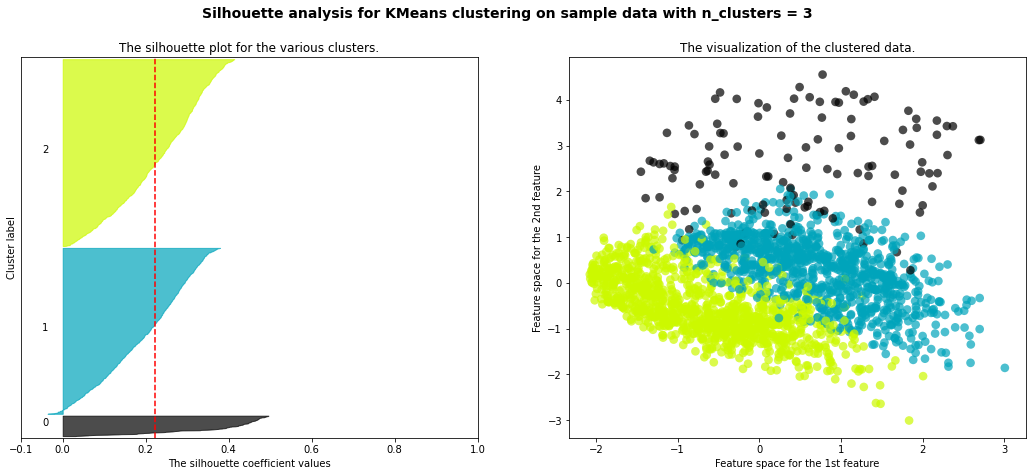

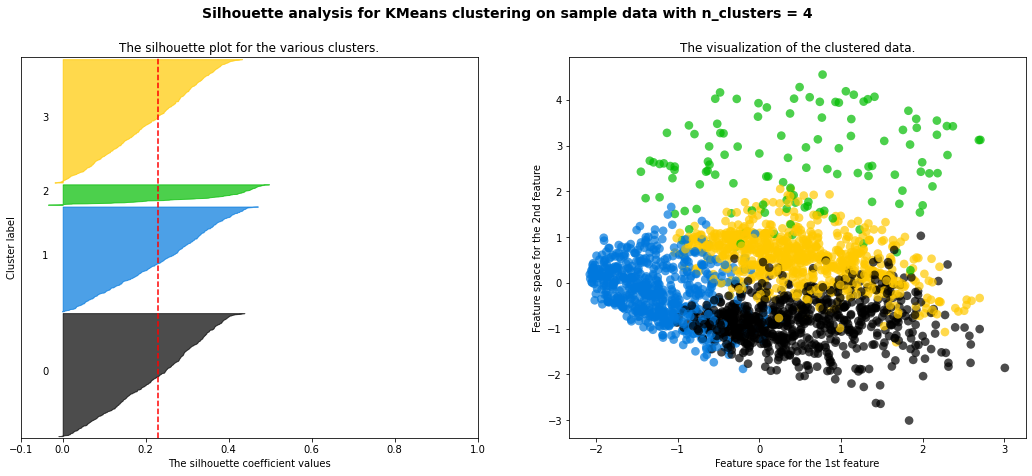

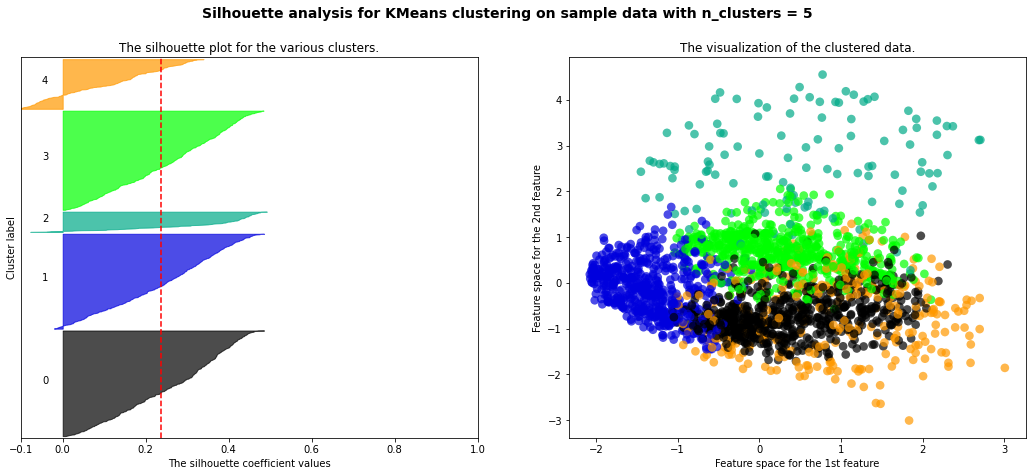

In [ ]:
plot_silhoette(model=KMeans, 
               X=X,
               X_2d=data_pca,
               max_num_clusters=6)

In [ ]:
df['hierarchical'] = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)

In [ ]:
fig = px.scatter_geo(df,
                    lat=df.Latitude,
                    lon=df.Longitude,
                    hover_name="hierarchical")
fig.show()

###Conclusion



*  According to expirement, the best number of clusters for KMeans is 3 or 4
*  DBSCAN performed not well 
*  According to labelled and unlabelled metrics the most similar algorithm to KMeans is Hierarchical clustering
* The best clusterizations is Hierarchical clustering according to metrics and visualization
* Best 2 algorithms are KMeans and Hierarchical clustering



That's it. Have a great day!